### 모터스 고객등급제 개편을 위한 분석 - 2. 데이터 전처리
--- 
#### 데이터 전처리 내역 
  1) 법인고객 제외 
  2) AS매출의 특이값 보정 : 음수값 및 200만원 이상건, 평균값(542189.5원)으로 대체 (55 + 266 = 321명 (3.45%))
  3) AS매출 가중치 적용 : NC매출 이익율 2%, AS 10% 이므로 AS매출을 5배(x5)함 
  4) NPS 6점 이하(비추천) 고객 마이너스 가중치 적용 : 매출액의 70%만 loyalty score에 적용 (x0.7)
  5) NC/AS 매출액 log 변환: 매출액 분포가 정규성을 띄지 않으므로   
--- 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes',unicode_minus=False)

In [2]:
## 1. 법인고객 제외된 dataset loading 
df = pd.read_excel('data/dataset_20230609.xlsx', sheet_name='data')
df = df.astype({'service_sales':'float64'})
df = df[df['customer_type'] == '개인']

print( df.shape )
print( df.columns)
df.head(2)

(8230, 22)
Index(['customer_name', 'hp', 'customer_type', 'gender', 'birth_day',
       'age_on_2023', 'show_room', 'series', 'model', 'model_category',
       'nc_sales', 'service_sales', 'tot_sales', '2023_sf_end', 'sf_due_date',
       'sf_real_end_date', 'sf_early_end_months', 'sf_early_end_yn',
       'nc_purchase_count', 'service_count', 'nps_score', 'nps_category'],
      dtype='object')


,customer_name,hp,customer_type,gender,birth_day,age_on_2023,show_room,series,model,model_category,...,tot_sales,2023_sf_end,sf_due_date,sf_real_end_date,sf_early_end_months,sf_early_end_yn,nc_purchase_count,service_count,nps_score,nps_category
0,이수진,010-4521-3503,개인,female,1978-04-16,46.0,청주,XSERIES,X4 xDrive 20d,X4,...,6.027242e+07,NaN,NaT,NaT,NaN,NaN,1,1,NaN,NaN
2,최인아,010-3245-1511,개인,NaN,1988-07-09,36.0,천안,XSERIES,X5 xDrive 30d,X5,...,9.642539e+07,NaN,NaT,NaT,NaN,NaN,1,0,NaN,NaN


In [3]:
## 2. AS매출의 특이값 보정 : 음수값 및 200만원 이상건, 평균값(542189원)으로 대체
df2 = df.copy()
df2.loc[(df2['service_sales'] < 0) | (df2['service_sales'] > 2000000) , 'service_sales'] = 542189.5

print('-조정전 AS매출 평균 =', np.mean(df['service_sales']))
print('-조정후 AS매출 평균 =', np.mean(df2['service_sales']))

-조정전 AS매출 평균 = 261081.06622114216
-조정후 AS매출 평균 = 105549.58450789793


In [4]:
## 3. AS매출 가중치 적용 : NC매출 이익율 2%, AS 10% 이므로 AS매출을 5배(x5)함
df3 = df2.copy()

##### weight ####################
k_as = 5 
################################

df3['service_sales'] = df2['service_sales']*k_as

print('-조정전 AS매출 평균 =', np.mean(df2['service_sales']))
print('-조정후 AS매출 평균 =', np.mean(df3['service_sales']))

-조정전 AS매출 평균 = 105549.58450789793
-조정후 AS매출 평균 = 527747.9225394897


In [5]:
## 4. NPS 6점 이하(비추천) 고객 마이너스 가중치 적용 : 매출액의 70%만 loyalty score에 적용 (x0.7)
df3_1 = df3[df3['nps_score'] > 6]
df3_2 = df3[df3['nps_score'] <= 6]
df3_3 = df3[df3['nps_score'].isnull()]

##### weight ####################
k_nps = 0.7 
################################

df3_2['nc_sales'] = df3_2['nc_sales']*k_nps
df3_2['service_sales'] = df3_2['service_sales']*k_nps
df3_2['tot_sales'] = (df3_2['nc_sales']+df3_2['service_sales'])
df4 = pd.concat([df3_1, df3_2, df3_3])

print('-조정전 NC매출 평균 =', np.mean(df3['nc_sales']))
print('-조정후 NC매출 평균 =', np.mean(df4['nc_sales']))
print('-조정전 AS매출 평균 =', np.mean(df3['service_sales']))
print('-조정후 AS매출 평균 =', np.mean(df4['service_sales']))
print('-조정전 Total매출 평균 =', np.mean(df3['tot_sales']))
print('-조정후 Total매출 평균 =', np.mean(df4['tot_sales']))

-조정전 NC매출 평균 = 68139446.98229316
-조정후 NC매출 평균 = 68028506.69316249
-조정전 AS매출 평균 = 527747.9225394897
-조정후 AS매출 평균 = 527252.0890643985
-조정전 Total매출 평균 = 68400528.0485143
-조정후 Total매출 평균 = 68290414.14850879


In [6]:
## 5. NC/AS 매출액 log 변환: 매출액 분포가 정규성을 띄지 않으므로
## 주의! AS매출에는 0이 다수 포함되어 있다. -> 모든 값들에 1을 더해준 후 로그변환 
df5 = df4.copy()
df5['log_nc_sales'] = np.log(df4['nc_sales'])
df5['log_service_sales'] = np.log1p(df4['service_sales'])
df5['log_tot_sales'] = np.log(df4['tot_sales'])

[Text(0.5, 1.0, 'NC sales - log변환 후')]

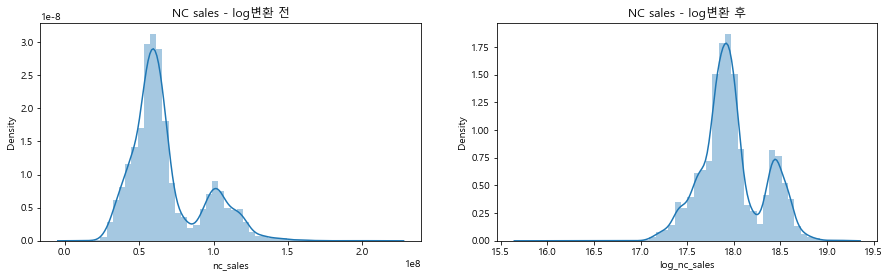

In [7]:
figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(15,4)
sns.distplot(df5['nc_sales'], ax=ax1)
sns.distplot(df5['log_nc_sales'], ax=ax2)
ax1.set(title = 'NC sales - log변환 전')
ax2.set(title = 'NC sales - log변환 후')

[Text(0.5, 1.0, 'AS sales - log변환 후')]

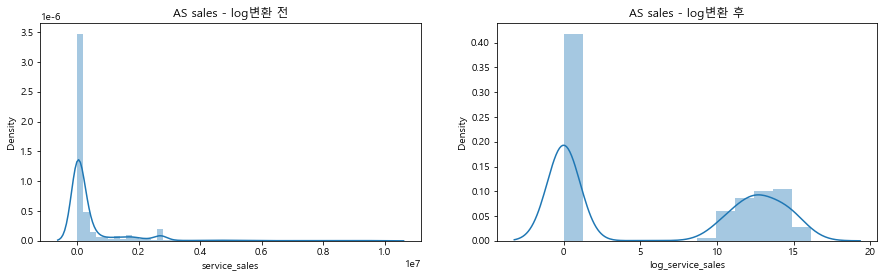

In [8]:
figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(15,4)
sns.distplot(df5['service_sales'], ax=ax1)
sns.distplot(df5['log_service_sales'], ax=ax2)
ax1.set(title = 'AS sales - log변환 전')
ax2.set(title = 'AS sales - log변환 후')

[Text(0.5, 1.0, 'Total sales - log변환 후')]

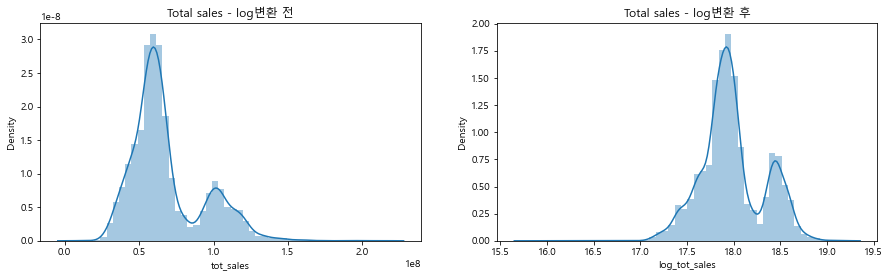

In [9]:
figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(15,4)
sns.distplot(df5['tot_sales'], ax=ax1)
sns.distplot(df5['log_tot_sales'], ax=ax2)
ax1.set(title = 'Total sales - log변환 전')
ax2.set(title = 'Total sales - log변환 후')

- 로그변환 후에도 정규분포와는 다소 거리가 있으나, 변환 전에 비해 많이 개선되었다. 

In [10]:
df4.to_csv('data/dataset_before_log.csv', index=False, encoding='euc-kr')
df5.to_csv('data/dataset_after_log.csv', index=False, encoding='euc-kr')